In [2]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.viewer import ImageViewer
from PIL import Image
import sys,os
import helper
import numpy as np
import matplotlib.pyplot as plt
    
def view_single_dim_image(image, dim=0):
    '''
    takes a lab image with dimensions (x, y, 3) and extracts
    the dimension specified. 
    possible values for dim are 0: l channel (grayscale), also default.
                                1: a channel (green to red)
                                2: b channel (blue to yellow)
    returns the image to view in rgb format
    '''
    one_dim_image = np.zeros_like(image)
    # Unless we set brightness, image will be to dark to view.
    if dim is not 0:
        one_dim_image[:,:,0] = 35
    one_dim_image[:,:,dim] = image[:,:,dim]
    return lab2rgb(one_dim_image)

def visualize_lab_images(images):
    num_samples = len(images)
    # figsize = (width, height)
    fig = plt.figure(figsize=(13,3*num_samples))
    fig_pos = 1
    for image in images:
        gray_scale = view_single_dim_image(image, dim=0)
        a_channel = view_single_dim_image(image, dim=1)
        b_channel = view_single_dim_image(image, dim=2)
        
        ax = fig.add_subplot(num_samples, 4, fig_pos)
        ax.imshow(lab2rgb(image))
        ax.axis("off")
        fig_pos += 1
        
        ax = fig.add_subplot(num_samples, 4, fig_pos)
        ax.imshow(gray_scale)
        ax.axis("off")
        fig_pos += 1
        
        ax = fig.add_subplot(num_samples, 4, fig_pos)
        ax.imshow(a_channel)
        ax.axis("off")
        fig_pos += 1
        
        ax = fig.add_subplot(num_samples, 4, fig_pos)
        ax.imshow(b_channel)
        ax.axis("off")
        fig_pos += 1
    
    plt.show()

class CatDogDataset(Dataset):
    def __init__(self, image_folder_path, input_transform=None, train=True):
        self.image_folder_path = image_folder_path
        self.images = os.listdir(self.image_folder_path)
        self.input_transform = input_transform

    def transform(self, image):
        # Resize
        # Add following for normalization: ,
                                #transforms.Normalize
                                #      (mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(256),
                                transforms.ToTensor()])
        resized_img = transform(image)
        # rgb2lab requires (256, 256, 3) and numpy-array
        # convert to PyTorch input format after conversion, i.e (3, 256, 256)
        lab_image = torch.from_numpy(rgb2lab(np.transpose(resized_img.numpy(),(1,2,0)))).permute(2,0,1)
        return lab_image[0,:,:].view(1,256,256), lab_image[1:3,:,:]

    def __getitem__(self, idx):
        image_file_name = self.images[idx]
        image = Image.open(os.path.join(self.image_folder_path, image_file_name))
        # PIL Image dimensions -> w, h = 300, 280
        #w, h = image.size
        #print(w, h)
        if self.input_transform is None:
            feature, target = self.transform(image)
        else: 
            feature, target = input_transform(image)
        return feature, target
    
    def __len__(self):
        return len(self.images)

    
def concat_L_with_AB(l, ab):
    image = np.zeros((3, 256, 256))
   # image[0,:,:] = l.cpu().view(1,256,256).numpy()[0,:,:]
   # image[1:3,:,:] = ab.cpu().view(2,256,256).detach().numpy()[1:3,:,:]
    image[0,:,:] = l.numpy()[0,:,:]
    image[1:3,:,:] = ab.numpy()[1:3,:,:]
    # transpose (3,256,256) => (256, 256, 3)
    #return torch.from_numpy(image).permute(1,2,0).numpy()
    return image.transpose(1,2,0)

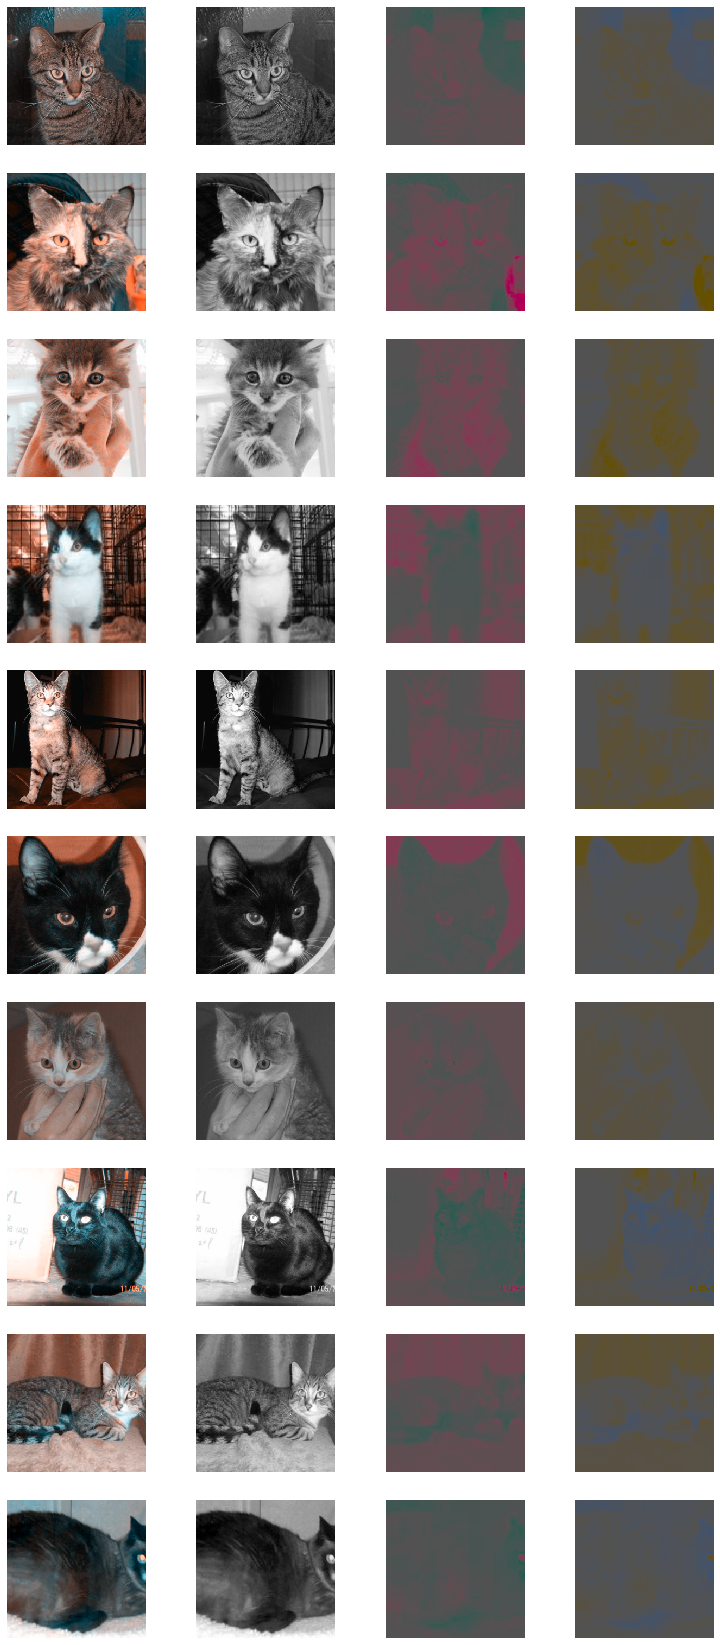

In [3]:
from data_path import training_data
catdog = CatDogDataset(training_data)
data_loader = DataLoader(catdog, batch_size=1)
images = []
count = 1

for f, t in data_loader:
    if count > 10:
        break
    y = concat_L_with_AB(f.view(1,256,256), t.view(2,256,256))  
   # images.append(y.view(256, 256, 3).numpy())
    images.append(y)
    count += 1

visualize_lab_images(images) 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        # Reference: https://github.com/richzhang/colorization/ ...
        #            blob/master/interactive-deep-colorization/ ...
        #            models/reference_model/deploy_nopred.prototxt
        
        # Needed BatchNorms: 
        self.bn_16 = nn.BatchNorm2d(16)
        self.bn_64 = nn.BatchNorm2d(64)
        self.bn_128 = nn.BatchNorm2d(128)
        self.bn_256 = nn.BatchNorm2d(256)
        self.bn_512 = nn.BatchNorm2d(512)
        
        # Conv Block 1, convolve and downsample
        # Pixels: 256x256 -> 128x128
        # Channels: 1 -> 64
        self.conv1_1 = nn.Conv2d(in_channels = 1,
                                 out_channels = 64,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv1_2 = nn.Conv2d(in_channels = 64,
                                 out_channels = 64,
                                 kernel_size = 3,
                                 stride = 2,
                                 padding = 1)
        
        # Conv Block 2, convolve and downsample
        # Pixels: 128x128 -> 64x64
        # Channels: 64 -> 128        
        self.conv2_1 = nn.Conv2d(in_channels = 64,
                                 out_channels = 128,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv2_2 = nn.Conv2d(in_channels = 128,
                                 out_channels = 128,
                                 kernel_size = 3,
                                 stride = 2,
                                 padding = 1)
        
        # Conv Block 3, convolve and downsample
        # Pixels: 64x64 -> 32x32
        # Channels: 128 -> 256  
        self.conv3_1 = nn.Conv2d(in_channels = 128,
                                 out_channels = 256,
                                 kernel_size = 4,
                                 padding = 1)
        self.conv3_2 = nn.Conv2d(in_channels = 256,
                                 out_channels = 256,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv3_3 = nn.Conv2d(in_channels = 256,
                                 out_channels = 256,
                                 kernel_size = 3,
                                 stride = 2,
                                 padding = 1)
        
        # Conv Block 4, convolve 
        # Pixels: 32x32
        # Channels: 256 -> 512  
        self.conv4_1 = nn.Conv2d(in_channels = 256,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv4_2 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv4_3 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 padding = 1)
        
        # Conv Block 5, convolve and dilate
        # Pixels: 32x32
        # Channels: 512  
        # Dilate: 2
        self.conv5_1 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 dilation = 2,
                                 padding = 2)
        
        self.conv5_2 = nn.Conv2d(in_channels = 512,
                             out_channels = 512,
                             kernel_size = 3,
                             dilation = 2,
                             padding = 2)
            
        self.conv5_3 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 dilation = 2,
                                 padding = 2)
        
        # Conv Block 6, convolve and dilate
        # Pixels: 32x32
        # Channels: 512  
        # Dilate: 2
        # Padding: 2
        self.conv6_1 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 dilation = 2,
                                 padding = 2)
        self.conv6_2 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 dilation = 2,
                                 padding = 2)
        self.conv6_3 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 dilation = 2,
                                 padding = 2)
        
        # Conv Block 7, convolve 
        # Pixels: 32x32
        # Channels: 512  
        self.conv7_1 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 padding = 1)
        
        self.conv7_2 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 padding = 1)
        
        self.conv7_3 = nn.Conv2d(in_channels = 512,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 padding = 1)
        
        # Conv Block 8, upsample/deconvolve 
        # Pixels: 32x32 -> 64x64
        # Channels: 512 -> 256
        self.conv8_1 = nn.ConvTranspose2d(in_channels = 512,
                                 out_channels = 256,
                                 kernel_size = 4,
                                 stride = 2,
                                 padding = 1)
    
        # INVESTIGATE SHORTCUT FROM REF, RESNET COMBINATION?
        self.conv8_2 = nn.Conv2d(in_channels = 256,
                                 out_channels = 256,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv8_3 = nn.Conv2d(in_channels = 256,
                                 out_channels = 256,
                                 kernel_size = 3,
                                 padding = 1)
        
        #### CUSTOM ####
        # Conv Block 9, upsample/deconvolve 
        # Pixels: 64x64 -> 128x128
        # Channels: 256 -> 128
        self.conv9_1 = nn.ConvTranspose2d(in_channels = 256,
                                 out_channels = 128,
                                 kernel_size = 4,
                                 stride = 2,
                                 padding = 1)
        self.conv9_2 = nn.Conv2d(in_channels = 128,
                                 out_channels = 128,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv9_3 = nn.Conv2d(in_channels = 128,
                                 out_channels = 128,
                                 kernel_size = 3,
                                 padding = 1)
        
        #### CUSTOM ####
        # Conv Block 10, upsample/deconvolve 
        # Pixels: 128x128 -> 258x258
        # Channels: 128 -> 2
        self.conv10_1 = nn.ConvTranspose2d(in_channels = 128,
                                 out_channels = 64,
                                 kernel_size = 4,
                                 stride = 2,
                                 padding = 1)
        self.conv10_2 = nn.Conv2d(in_channels = 64,
                                 out_channels = 32,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv10_3 = nn.Conv2d(in_channels = 32,
                                 out_channels = 16,
                                 kernel_size = 3,
                                 padding = 1)
        self.conv10_4 = nn.Conv2d(in_channels = 16,
                                 out_channels = 2,
                                 kernel_size = 3,
                                 padding = 1)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.bn_64(x)
        # Block 2 
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.bn_128(x)
        # Block 3
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.bn_256(x)
        # Block 4
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.bn_512(x)
        # Block 5
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.bn_512(x)
        # Block 6
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = F.relu(self.conv6_3(x))
        x = self.bn_512(x)
        # Block 7
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = F.relu(self.conv7_3(x))
        x = self.bn_512(x)
        # Block 8
        x = F.relu(self.conv8_1(x))
        x = F.relu(self.conv8_2(x))
        x = F.relu(self.conv8_3(x))
        x = self.bn_256(x)
        # Block 9
        x = F.relu(self.conv9_1(x))
        x = F.relu(self.conv9_2(x))
        x = F.relu(self.conv9_3(x))
        x = self.bn_128(x)
        # Block 10
        x = F.relu(self.conv10_1(x))
        x = F.relu(self.conv10_2(x))
        x = F.relu(self.conv10_3(x))
        x = self.bn_16(x)
        x = self.conv10_4(x)
        
                    
        return x

In [ ]:
import torch.optim as optim
lr = 0.001
model = ColorNet()
params = model.parameters()
# Regression Loss
criterion = nn.MSELoss().cuda()
optimizer = torch.optim.Adam(params, lr = lr)
# move tensors to GPU if CUDA is available
gpu_available = torch.cuda.is_available()
model.cuda()

In [ ]:
catdog = CatDogDataset(training_data)
batch_size = 24
data_loader = DataLoader(catdog, batch_size=batch_size)
n_epochs = 10
len_data = len(catdog)
num_batches = len_data/batch_size
model.train()
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(data_loader):
        # move tensors to GPU if CUDA is available
        if gpu_available:
            data, target = data.float().cuda(), target.float().cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        #print(output.shape)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss, loss.item is the avarage loss of the batch.
        train_loss += loss.item()*data.size(0)
        if batch_idx % 50 == 0:
            print('Batch: {:d}/{:d}, Loss: {:d}'.format(int(batch_idx + ((epoch-1)*num_batches)), int((num_batches*n_epochs)), (int(loss.item()*data.size(0)))))
    train_loss = train_loss/len(data_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [ ]:
state = {'epoch': epoch, 
         'state_dict': model.state_dict(),
         'optimizer': optimizer.state_dict()}

torch.save(state, 'dog_cat_net.pth')

In [ ]:
#checkpoint = torch.load('dog_cat_net.pth')
#model = ColorNet()
#model.load_state_dict(checkpoint['state_dict'])
model.eval()

gs, ab = catdog[0]
gs = gs.view(1,1,256,256).float().cuda()
ab = model(gs)

def concat_L_with_AB(l, ab):
    image = np.zeros((3, 256, 256))
    image[0,:,:] = l.cpu().view(1,256,256).numpy()[0,:,:]
    image[1:3,:,:] = ab.cpu().view(2,256,256).detach().numpy()[1:3,:,:]
    #image[0,:,:] = l.numpy()[0,:,:]
    #image[1:3,:,:] = ab.numpy()[1:3,:,:]
    # transpose (3,256,256) => (256, 256, 3)
    #return torch.from_numpy(image).permute(1,2,0).numpy()
    return image.transpose(1,2,0)

image = concat_L_with_AB(gs, ab)
images = [image]
print(image.shape)
visualize_lab_images(images)

In [ ]:
# Define Blocks to use in Model
class downsample_2_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = 3,
                               stride = 2)
        self.relu = nn.ReLu()
        self.bn = nn.BatchNorm2d(num_features = out_channels)

        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn(x)
        return x
    
class downsample_3_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels,
                               out_channels = out_channels,
                               kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = 3)
        self.conv3 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = 3,
                               stride = 2)
        self.relu = nn.ReLu()
        self.bn = nn.BatchNorm2d(num_features = out_channels)

        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.bn(x)
        return x
        
    
class convolution_block(nn.Module):
    def __init__(self, in_out_channels, dilution=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = in_out_channels
                               out_channels = in_out_channels,
                               kernel_size = 3,
                               dilation=dilation)
        self.conv2 = nn.Conv2d(in_channels = in_out_channels,
                               out_channels = in_out_channels,
                               kernel_size = 3,
                               dilation=dilation)
        self.conv3 = nn.Conv2d(in_channels = in_out_channels,
                               out_channels = in_out_channels,
                               kernel_size = 3,
                               dilation=dilation)
        self.relu = nn.ReLu()
        self.bn = nn.BatchNorm2d(num_features = in_out_channels)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.bn(x)
        return x

class upsample_block(nn.Module):
    def __init__(self, in_channels, out_channels, dilution=1):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels = in_channels,
                                          out_channels = out_channels,
                                          kernel_size = 4,
                                          stride = 2)
        self.conv1 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = 3,
                               dilation=dilation)
        self.conv2 = nn.Conv2d(in_channels = out_channels,
                               out_channels = out_channels,
                               kernel_size = 3,
                               dilation=dilation)
        self.relu = nn.ReLu()
        self.bn = nn.BatchNorm2d(num_features = in_out_channels)
        
    def forward(self, x):
        x = self.relu(self.deconv1(x))
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.bn(x) 
        return x
    